In [1]:
import warnings
warnings.filterwarnings('ignore')

from math import pi, sin, cos, sqrt, sinh 
import pylab as plt
import numpy as np
import os
os.chdir('C:/Users/Renan/Desktop/dsai-thesis')

from segmentation_models.condnet.data_loader import load_dataset
from segmentation_models.condnet.utils import transforms_init
import macromax
inputs, targets = load_dataset('train')

In [2]:
transformA, transformB = transforms_init(256)
sample = targets[1325:1326, :, :, :]
sample = transformA(sample)
trial  = sample[0, 0, :, :].detach().numpy()

In [3]:
def _basic_check(A, b, x0):
    n, m = A.shape
    if(n != m):
        raise ValueError("Only square matrix allowed")
    if(b.size != n):
        raise ValueError("Bad rhs size")
    if (x0 is None):
        x0 = np.zeros(n)
    if(x0.size != n):
        raise ValueError("Bad initial value size")
    return x0

def _basic_check_VCycle(A, u0, B, l):
    n, m = A.shape
    if (n != m):
        raise ValueError("A should be square")
    elif (n != u0.size) or (n != B.size):
        raise ValueError("B, u0 and A should have the same length")
    elif (u0.size//(2*l) <= 1):
        raise ValueError("l is very big, try {} or less".format((1/6)*u0.size - 1))

def _basic_check_WCycle(A, u0, B, l, s):
    n, m = A.shape
    if (n != m):
        raise ValueError("A should be square")
    elif (n != u0.size) or (n != B.size):
        raise ValueError("B, u0 and A should have the same length")
    elif (u0.size//(2*l) <= 1):
        raise ValueError("l is very big, try {} or less".format((1/6)*u0.size - 1))
    if (l < s):
        raise ValueError("l should be bigger than or equal m !")

def laplace_1D(n):
    A = np.zeros((n,n))
    A[0][0],A[0][1] = 2, -1
    A[n-1][n-1],A[n-1][n-2] = 2, -1
    for i in range(1,n-1):
        A[i][i], A[i][i-1], A[i][i+1] = 2, -1, -1
    A *= (n-1)**2
    return A

def laplace_2D(n, gamma):
    A = np.zeros((n**2,n**2))
    A[0][0],A[0][1], A[0][n] = 4, -1, -1
    A[n**2-1][n**2-1], A[n**2-1][n**2-2], A[n**2-1][n**2-n-1] = 4, -1, -1
    for i in range(1,n**2-1):
        if i < n:
            A[i][i], A[i][i-1], A[i][i+1], A[i][i+n] = 4, -1, -1, -1
        elif i >= n*(n-1):
            A[i][i], A[i][i-1], A[i][i+1], A[i][i-n] = 4, -1, -1, -1
        else:
            A[i][i], A[i][i-1], A[i][i+1], A[i][i-n], A[i][i+n] = 4, -1, -1, -1, -1              
    A *= (n-1)**2
    A += gamma*np.identity((n)**2)
    return A

def laplace_2D_as(n, epsilon):
    A = np.zeros((n**2, n**2))
    A[0][0],A[0][1], A[0][n] = 2*(epsilon + 1), -1, -epsilon
    A[n**2-1][n**2-1], A[n**2-1][n**2-2], A[n**2-1][n**2-n-1] = 2*(epsilon + 1), -1, -epsilon
    for i in range(1,n**2-1):
        if i < n:
            A[i][i], A[i][i-1], A[i][i+1], A[i][i+n] = 2*(epsilon + 1), -1, -1, -epsilon
        elif i >= n*(n-1):
            A[i][i], A[i][i-1], A[i][i+1], A[i][i-n] = 2*(epsilon + 1), -1, -1, -epsilon
        else:
            A[i][i], A[i][i-1], A[i][i+1], A[i][i-n], A[i][i+n] = 2*(epsilon + 1), -1, -1, -epsilon, -epsilon            
    A *= (n-1)**2
    return A

import warnings
warnings.filterwarnings('ignore')

def LS_solver(A, b, x0 = None, method = 'SOR', omega = 1.4, eps = 1e-12, maxiter = 50):
    residual_history = list()
    x = _basic_check(A, b, x0)
    r = np.zeros(x.shape)
    z = np.ones(x.shape)
      
    if method   is 'JOR':
        M = (1/omega) * np.diag(np.diag(A))
    elif method is 'SOR':
        if (omega > 2.) or (omega < 0.):
            raise ArithmeticError('SOR will diverge')
            
        E = -np.tril(A, k = -1)
        M = ((1/omega) * np.diag(np.diag(A))) - E
    else:
        raise ValueError('''The chosen 'method' doesnt exist or not taken into consideration''')
    iter = 0
    while ((iter < maxiter) and (np.linalg.norm(z) > eps)):
        r = b-A.dot(x)
        z = (np.linalg.inv(M)).dot(r)
        x += z
        residual_history.append(np.linalg.norm(r))
        iter+=1
    return x, residual_history

def I(n, to = None):
    n = int(n)
    I_mat = np.zeros((n//2 ,n))
    
    for i in range(n//2):
        I_mat[i][2*i+1], I_mat[i][2*i], I_mat[i][2*i+2] = 2, 1, 1
    
    if to is 'coarse':
        return 0.25 * I_mat

    elif to is 'fine':
        return 0.5 * I_mat.transpose()

def I_2D(n, to=None, wmethod="fw", init = None):
    if init == None:
        I_mat = np.kron(4*I(n, to = "coarse"),4*I(n, to = "coarse"))
    else:
        I_mat = n
    if wmethod is "fw":
        if to is "coarse":
            return (1/16)*I_mat
        elif to is "fine":
            return (1/4)*I_mat.transpose()
    elif wmethod is "hw":
        I_mat = np.where(I_mat==1, 0, I_mat)
        I_mat = np.where(I_mat==2, 1, I_mat)
        if to is "coarse":
            return (1/8)*I_mat
        elif to is "fine":
            return (1/4)*I_mat.transpose()
    else:
        raise ValueError('''The chosen 'method' doesnt exist or not taken into consideration''')

def mgVcyc(A, u0, B, l = 4, v1_iter = 3, v2_iter = 1, dim = 2, wmethod = 'fw'):
    _basic_check_VCycle(A, u0, B, l)

    if dim == 2:
        n_inc_h = int(sqrt(u0.size))
    else:
        n_inc_h = u0.size
    n_inc_H = n_inc_h//2

    A_h = A 
    if dim == 2:
        A_H = (I_2D(n_inc_h, to = 'coarse', wmethod = wmethod).dot(A_h)).dot(I_2D(n_inc_h, to = 'fine', wmethod = wmethod))
    else:
        A_H = (I(n_inc_h, to = 'coarse').dot(A_h)).dot(I(n_inc_h, to = 'fine'))
    u = u0
    b_h = B

    u_s = LS_solver(A_h, b_h, x0=u, method="JOR", omega=0.5, eps = 1e-12, maxiter=v1_iter)[0]
    d_h = b_h - A_h.dot(u_s)

    if dim == 2:
        d_H = I_2D(n_inc_h, to="coarse", wmethod=wmethod).dot(d_h)
    else:
        d_H = I(n_inc_h, to="coarse").dot(d_h)
    if l == 1:
        v_H = np.linalg.solve(A_H, d_H) 
    else:
        v_H = mgVcyc(A_H, np.zeros(n_inc_H**dim), d_H, l=l-1, v1_iter=3, v2_iter=3, dim=dim)
    if dim == 2:
        v_h = I_2D(n_inc_h, to="fine", wmethod=wmethod).dot(v_H)
    else:
        v_h = I(n_inc_h, to="fine").dot(v_H) 
    u = u_s + v_h 
    u = LS_solver(A_h, b_h, x0=u, method="JOR", omega=0.5, eps=_eps, maxiter=v2_iter)[0]
    return u

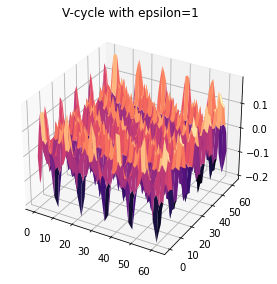

<Figure size 1440x1080 with 0 Axes>

In [5]:
fig = plt.figure(figsize=(20, 10))
_n = 63
_eps = 1e-12
epsilon_list = [1]
for e in range(0, 1):
    epsilon = epsilon_list[e]
    A = laplace_2D_as(_n, epsilon)
    x0 = []
    for i in range(0,_n):
        for j in range(0, _n):
            x0.append(cos(10*i*pi/_n)*sin(10*j*pi/_n))
    x0 = np.array(x0)

    b  = np.zeros(_n ** 2)

    X = np.arange(0, _n)
    Y = np.arange(0, _n)
    X, Y = np.meshgrid(X, Y)
    
    Z = mgVcyc(A, x0, b, l = 3, v1_iter = 3, v2_iter = 1, dim = 2)
    Z = np.reshape(Z, (-1, _n))
    plt.figure(figsize = (20, 15))
    ax = fig.add_subplot(2, 3, e + 1, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='magma')
    ax.set_title("V-cycle with epsilon={}".format(epsilon))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn import preprocessing
import timeit
import timer

def func(x,y):
	return -2.0*(np.pi**2)*np.sin(np.pi*(x))*np.sin(np.pi*(y))

def solution(dims):
	h_x = 1.0/(dims[0] + 1)
	h_y = 1.0/(dims[1] + 1)
	u = np.zeros((dims[0] + 2, dims[1] + 2))
	for x_i in range(1, dims[0]+1):
		for y_j in range(1, dims[1]+1):
			u[x_i, y_j] = np.sin(np.pi*h_x*x_i)*np.sin(np.pi*h_y*y_j)
	return u

"""
This is a function to populate a matrix that acts as the right hand function evaluated over a discrete grid. 
Inputs to this function is a list of grid point sizes, i.e. [Nx, Ny] and a pointer to mathematical function.
The put is a matrix b.
"""
def create_B(dims, func):
	h_x = 1.0/(dims[0] + 1)
	h_y = 1.0/(dims[1] + 1)

	b = np.zeros((dims[0]+2, dims[1]+2))

	for x_i in range(1, dims[0]+1):
		for y_j in range(1, dims[1]+1):
			b[x_i, y_j] = func(h_x*x_i, h_y*y_j)

	return b

"""
Smoothing function used by multigrid method. The smoothing is done by applying N Gauss-Seidel iteration.
The inputs:
	T - a matrix of Nx+2, Ny+2 elements that is used to approximate the solution of the partial differential equation. 
	b - right hand side of the partial differential equation.
	dims - a list of grid sizes.
	steps - the number of smoothing iterations
Outputs:
	Returns an updated version of T
"""
def smooth(T, b, dims, steps):
	h_x = 1.0/(dims[0] + 1)
	h_y = 1.0/(dims[1] + 1)
	N = dims[0]*dims[1]

	for k in range(steps):
		
		for y_j in range(1, dims[1]+1):
			for x_i in range(1, dims[0] + 1):
				T[x_i, y_j] = ( (T[x_i-1, y_j] + T[x_i+1,y_j])/(h_x**2) + (T[x_i, y_j+1] + T[x_i, y_j-1])/(h_y**2) - (b[x_i,y_j]))/(2.0/(h_x**2) + 2.0/(h_y**2))

	return T

"""
Residual function used by multigrid method and it gives an quantified measure of how close is the numerical solution is to the exact solution. When the resiudal is zero, it means that T solve the system of algebraic equations that approximates the partial differential equation. 
The inputs:
	T - a matrix of Nx+2, Ny+2 elements that is used to approximate the solution of the partial differential equation. 
	b - right hand side of the partial differential equation.
	dims - a list of grid sizes.
Outputs:
	y - residual
	res_temp - norm of the residual
"""
def residual(T, b, dims):
	h_x = 1.0/(dims[0] + 1)
	h_y = 1.0/(dims[1] + 1)
	y = np.zeros((dims[0]+2, dims[1]+2))
	 
	sum_temp = 0.0
	for x_i in range(1, dims[0]+1):
		for y_j in range(1, dims[1]+1):
			y[x_i, y_j] = -(T[x_i-1, y_j] - 2*T[x_i,y_j] + T[x_i+1, y_j])/(h_x**2) - (T[x_i, y_j-1] - 2*T[x_i,y_j] + T[x_i, y_j+1])/(h_y**2) + b[x_i,y_j]
			sum_temp += y[x_i, y_j]**2;

	res_temp = np.sqrt(sum_temp)

	return y, res_temp


"""
restriction function which maps the matrix on a fine grid to a coarser grid
The inputs:
	T - a matrix of Nx+2, Ny+2 elements that is used to approximate the solution of the partial differential equation on a fine grid.
	dims - a list of grid sizes.
Outputs:
	E - projection of T onto a coarser grid.
"""
def restriction(T, dims):
	E = np.zeros((dims[0]+2, dims[1]+2))
	for i in range(1,dims[0]+1):
		for j in range(1, dims[1]+1):
			E[i,j] = T[2*(i), 2*j ]

	return E

"""
Interpolation function which maps matrices on coarse grids to a finer ones. It uses bi-linear interpolation to acheive its goal.
The inputs:
	T - a matrix of Nx+2, Ny+2 elements that is used to approximate the solution of the partial differential equation on a coarse grid.
	dims - a list of grid sizes.
Outputs:
	E - projection of T onto a finer grid.
"""
def interpolation(T, dims):
	E = np.zeros((dims[0]+2, dims[1]+2))
	Nx_2 = int(np.floor(dims[0]/2))
	Ny_2 = int(np.floor(dims[1]/2))

	for i in range(0, Nx_2+ 1):
		for j in range(0,Ny_2+1):
			E[2*i, 2*j] = T[i,j]
			E[2*i, 2*j + 1] = (T[i,j] + T[i,j+1])/2.0
			E[2*i + 1, 2*j] = (T[i+1,j] + T[i,j])/2.0
			E[2*i + 1, 2*j+ 1] = (T[i,j] + T[i,j+1] + T[i+1,j] + T[i+1,j+1])/4.0

	return E

"""
V-Cycle function which is the core of multigrid method. This is a recursive function that applies smoothing to the error mapped to different coearser grids and then interpolated and used as correction term.
The inputs:
	T - a matrix of Nx+2, Ny+2 elements that is used to approximate the solution of the partial differential equation on the finest grid. 
	b - the right hand side of the equation
	dims - a list of grid sizes.
	steps - a list with the number of pre-smoothing and post-smoothing iterations
Outputs:
	T - the updated value of T
	res_norm - norm of the residual.
"""
def vCycle(T, b, dims, steps):
	N = dims[0] * dims[1]
	T = smooth(T, b, dims, steps[0])
	if dims[0] >= 3 and dims[1] >= 3:
		res, _ = residual(T,b,dims)
		dims_s = [int(np.floor(dims[0]/2.0)),int(np.floor(dims[1]/2.0))]
		res_s = restriction(res, dims_s)
		T_2 = np.zeros((dims_s[0] + 2, dims_s[1] + 2))
		T_2, _ = vCycle(T_2, res_s, dims_s, steps )
		T_3 = interpolation(T_2, dims)
		T = T + T_3
	T = smooth(T, b, dims, steps[1])

	res, res_norm = residual(T,b,dims)
	res_norm = (1.0/N) * np.sqrt(res_norm)

	return T, res_norm

In [4]:
def image_acquire(targets, index):
    image = targets[index : index + 1, :, :, :]
    image = transformA(image)
    image = image[0, 0, :, :].detach().numpy()
    return image

def vcycle(image, display = False):
    Nx = image.shape[0] - 2; Ny = image.shape[0] - 2
    dims = [Nx, Ny]
    B = create_B(dims, func)
    res_mg = 1.0 
    counter = 0
    steps = [5, 3]

    tol = 0.0005
    max_iter = 2000
    while (res_mg > tol and counter < max_iter):
        if display:
            if counter % 50 == 0:
                print(f'Counter {counter} \t Loss {res_mg:.5f}')
    counter += 1
    result, res_mg = vCycle(image, B, dims, steps)
    result = image
    return result

def compute_density(image, result):
    J = image * result
    for i in range(J.shape[0]):
        for j in range(J.shape[1]):
            if J[i][j] > 3.2:
                J[i][j] = np.min(J)
    return J

def plot_potential(image, result, num = 1000, save = False):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15, 4))

    plot1 = ax1.contourf(image,  cmap = 'inferno')
    ax1.set_title(r'Conductivity $\sigma_q [S/m]$', size = 15)
    plot2 = ax2.contourf(compute_density(image, result), cmap = 'inferno')
    ax2.set_title(r'Electrical Density $J[A/m^2]$ Flow', size = 15)
    plot3 = ax3.contourf(result, cmap = 'inferno')
    ax3.set_title(r'Potential $\phi [A/m^2]$ Flow', size = 15)
    
    fig.colorbar(plot1, label = 'Conductivity $\sigma_q [S/m]$', ax = ax1)
    fig.colorbar(plot2, label = '$J[A/m^2]$', ax = ax2)
    fig.colorbar(plot3, label = '$J[A/m^2]$', ax = ax3)
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig(f'{num}.png')

def create_potentials(targets):
    for num in range(1000, 1001):
        image  = image_acquire(targets, num)
        result = vcycle(image, display = False)
        plot_potential(image, result, num, save = True)

In [5]:
sample = targets[986:987, :, :, :]
sample = transformA(sample)
trial  = sample[0, 0, :, :].detach().numpy()

In [6]:
Nx = trial.shape[0] - 2; Ny = trial.shape[0] - 2
dims = [Nx, Ny]
B = create_B(dims, func)
res_mg = 1.0; counter = 0;
steps = [5, 3]

tol = 0.0005
max_iter = 2000
while (res_mg > tol and counter < max_iter):
  if counter % 50 == 0:
    print(f'Counter {counter} \t Loss {res_mg:.5f}')
  counter += 1
  result, res_mg = vCycle(trial, B, dims, steps)
result = trial

Counter 0 	 Loss 1.00000


In [7]:
import csv
from numpy import cos, sin, abs, pi, array, append, copy, linspace, sqrt, mean

def read_electrode_locations():
    '''Reads electrode locations from a previously prepared text file'''
    reader = csv.reader(open('esl/electrodeLocations.elp', 'r'), dialect = 'excel-tab')

    electrodes = []
    electrode_theta = []
    electrode_phi = []
    electrode_x = []
    electrode_y = []

    for row in reader:
        if reader.line_num != 1:
            electrodes.append(row[1])
            electrode_theta.append(float(row[2]))
            electrode_phi.append(float(row[3]))

    max_theta = max(electrode_theta)
    electrode_theta = array(electrode_theta)
    electrode_theta = electrode_theta / max_theta
    
    for i in range(len(electrodes)):
        electrode_x.append(electrode_theta[i] *\
                           cos(electrode_phi[i] / 180 * pi))
        electrode_y.append(electrode_theta[i] *\
                           sin(electrode_phi[i] / 180 * pi))

    for i in range(len(electrode_theta)):
        if electrode_theta[i] < 0:
            electrode_phi[i] = electrode_phi[i] / 180 * pi + pi
        else:
            electrode_phi[i] = electrode_phi[i] / 180 * pi
    electrode_theta = abs(electrode_theta) * pi / 2
    return [electrodes, electrode_x, electrode_y, electrode_theta, electrode_phi]

def show_slices(slices):
   ''' Function to display row of image slices'''
   if len(slices) > 1:
       fig, axes = plt.subplots(1, len(slices))
       for i, slice in enumerate(slices):
           axes[i].imshow(slice.T, cmap = "inferno", origin = "lower")
   else:
       plt.figure(figsize = (7, 6))
       plt.imshow(slices[0].T, cmap = 'inferno', origin = 'lower')
[electrodes, electrode_x, electrode_y, electrode_theta, electrode_phi] = read_electrode_locations()

In [20]:
import h5py    
import numpy as np    
import matplotlib.pyplot as plt 

directory = 'D:/SimNIBS-3.2/matlab/leadfield/T1W-012_leadfield_EEG10-10_UI_Jurak_2007.hdf5'
leadfield = h5py.File(directory, 'r')
leadfieldmatrix = leadfield['mesh_leadfield']['leadfields']['tdcs_leadfield']
leadfieldmatrix = leadfieldmatrix[:]
leadfieldmatrix = leadfieldmatrix.reshape((leadfieldmatrix.shape[0], leadfieldmatrix.shape[1] * leadfieldmatrix.shape[2]))
leadfieldmatrix = leadfieldmatrix
leadfieldmatrix.shape

def matchingpursuit(leadfieldmatrix, potential):
    corrcoef = []
    M, N = 75, 245331
    assert leadfieldmatrix.shape[0] == M
    assert leadfieldmatrix.shape[1] == 3 * N
    assert potential.shape[0] == M 

    for i in range(0, leadfieldmatrix.shape[1]):
        corr_num = np.inner(potential[:], leadfieldmatrix[:, i])
        corr_den = np.linalg.norm(potential) * np.linalg.norm(leadfieldmatrix[:, i])
        corrcoef.append(corr_num / corr_den)
    sources = np.asarray(corrcoef)
    soruces = np.argmax(sources)
    return sources

potential = np.cov(leadfieldmatrix)[:, 0]
sources = matchingpursuit(leadfieldmatrix, potential)
estimated = []
for idx in range(leadfieldmatrix.shape[1]):
    estimated.append(np.argmax(leadfieldmatrix[:, idx] - sources[idx, ]))

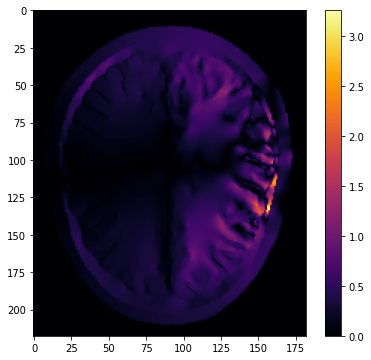

In [46]:
import SimpleITK as sitk

file = 'D:/thesis-eegsource/T1W-012/eeg-fp/T1W-012 T1/mni_volumes/T1W-012_TMS_1-0001_MagVenture_MC_B70_nii_scalar_MNI_E.nii.gz'
sample = sitk.GetArrayFromImage(sitk.ReadImage(file))


plt.figure(figsize = (7, 6))
plt.imshow(np.abs(sample[0, 100, :, :]), cmap = 'inferno')
plt.colorbar()